# FAIRshake AGR Datasets Evaluation Summary

In [62]:
print("Created by Brian Schilder, 07/22/2018\n")
print("Modified by Megan Wojciechowicz, 07/23/2018\n")
import sys
print("Python Version Info:")
print(sys.version)


Created by Brian Schilder, 07/22/2018

Modified by Megan Wojciechowicz, 07/23/2018

Python Version Info:
3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## Summary Questions
- Average score for each question
- Standard deviation for each answer
- Correlation between questions
- Evals per person, max evals, and distribution
- Are some people generally harsher
- Which answers tended to have comments
- FAIRest tools vs. Least FAIR tools

## FAIRshake Questions
1. ID/ACCESSION : A standardized ID or accession number is used to identify the dataset.
2. METADATA : The dataset is described with metadata using a formal, broadly applicable vocabulary. 
3. EXPERIMENT : Information is provided on the experimental methods used to generate the data. 
4. REPOSITORY : The dataset is hosted in an established data repository, if a relevant repository exists. 
5. DOWNLOAD : The dataset can be downloaded for free from the repository. 
6. VERSIONING : Version information is provided for the dataset.
7. CONTACT: Contact information is provided for the creator(s) of the dataset. 
8. CITATION : Information is provided describing how to cite the dataset. 
9. LICENSE : Licensing information is provided on the dataset’s landing page. 


In [63]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib
# matplotlib.rcParams.update({'font.size': 18})

import pandas as pd
fair = pd.read_json("fairshake_db_no_limit.json")
fair.shape
fair.columns

# Only select rows that had a q_id's >9 and <19
fair = fair[fair['q_id'] >9]
fair = fair[fair['q_id'] <19]
fair['q_id'] = pd.Categorical(fair['q_id'])
qDict = {10:'1. ID/Accession', 11:'2. Metadata', 12:'3. Experiment', 13:'4. Repository', 
         14:'5. Download', 15:'6. Versioning', 16:'7. Contact', 17:'8. Citation', 18:'9. License'}
fair["q_name"] = fair['q_id'].map(qDict)

## Average score for each question

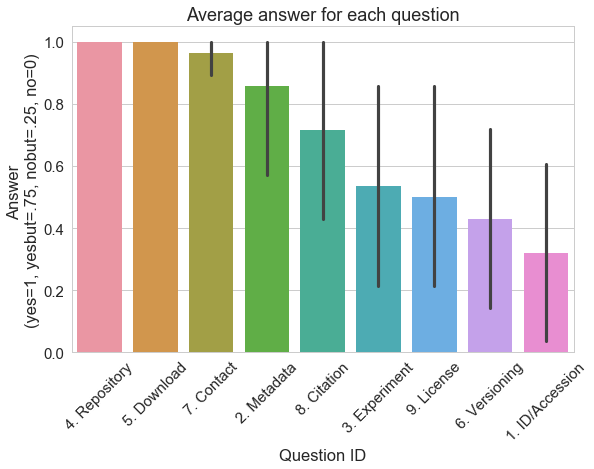

In [64]:
import seaborn as sn
sn.set(font_scale=1.5)
import matplotlib.pyplot as plt
sn.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6) 

#fair.answer.unique()
fair["answer01"] = fair.answer.map(dict(yes=1, no=0, yesbut=.75, nobut=.25))
avg_per_q = fair.groupby('q_name')['q_name','answer01'].mean()
std_per_q = fair.groupby('q_name')['q_name','answer01'].std()
avg_per_q.rename(columns={'answer01':'answer01_mean'}, inplace=True)
avg_per_q = avg_per_q.sort_values(by='answer01_mean', ascending=False)

## plot
#fair = fair.merge(avg_per_q, on='q_id')
g = sn.barplot(data=fair, x='q_name', y='answer01', order=avg_per_q.index)
## ax = sn.violinplot(data=fair, x='q_id', y='answer01', order=avg_per_q.index)
g.set(ylabel='Answer \n(yes=1, yesbut=.75, nobut=.25, no=0)', xlabel='Question ID', title="Average answer for each question")
plt.xticks(rotation=45, ha='center')
plt.show()

## Frequency of each of the 4 score options for each question

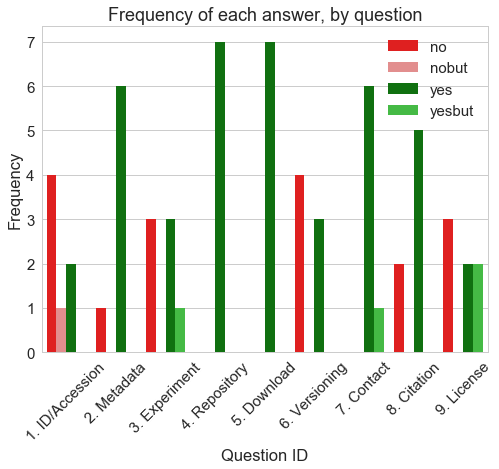

In [65]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

scores4 = fair.groupby(['q_name','answer'])['answer'].count()
scores4.name = 'answerCount'
scores4 = scores4.reset_index()
palette ={"no":"red","nobut":"lightcoral", "yes":"green", "yesbut":"limegreen"}
g = sn.barplot(data=scores4, x='q_name', y='answerCount', hue='answer', palette=palette)
g.set(ylabel='Frequency', xlabel='Question ID', title="Frequency of each answer, by question")
g.legend()
plt.xticks(rotation=45, ha='center')
plt.show()

## Correlations between questions

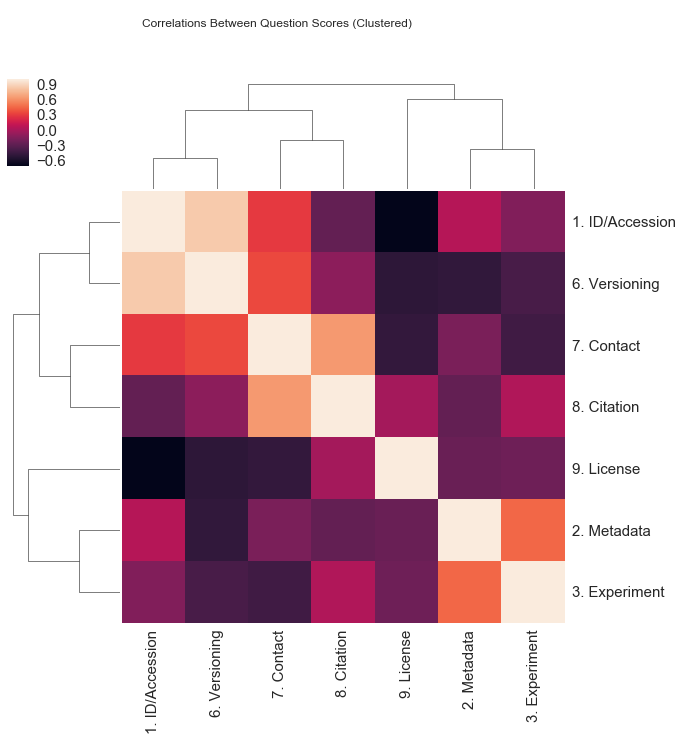

There is some correlation between q1 (ID/Accession) and q6 (Versioning).
There is some correlation between q7 (Contact) and q8 (Citation).
There is some correlation between q2 (Metadata) and q3 (Experiment).
There is some correlation between q6 (Versioning) and q7 (Contact).
There is some correlation between q1 (ID/Accession) and q7 (Contact).


In [66]:
import seaborn as sns
#fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

corrDict={}
for q in fair['q_name']:
    sub = fair.loc[fair['q_name']==q]['answer01']
    corrDict[q] = sub.values
corrMatrix = pd.DataFrame(corrDict).corr()
corrMatrixNew = corrMatrix.drop(['4. Repository'], axis=1) # drop download and repository questions since all responses = TRUE
corrMatrixNew = corrMatrixNew.drop(['5. Download'], axis=1)
corrMatrixNew = corrMatrixNew.drop(corrMatrixNew.index[[3]])
corrMatrixNew = corrMatrixNew.drop(corrMatrixNew.index[[3]])
sns.clustermap(data=corrMatrixNew).fig.suptitle('\nCorrelations Between Question Scores (Clustered)', size=12)
plt.show()

print("There is some correlation between q1 (ID/Accession) and q6 (Versioning).")
print("There is some correlation between q7 (Contact) and q8 (Citation).")
print("There is some correlation between q2 (Metadata) and q3 (Experiment).")
print("There is some correlation between q6 (Versioning) and q7 (Contact).")
print("There is some correlation between q1 (ID/Accession) and q7 (Contact).")

## Evaluations Per Person

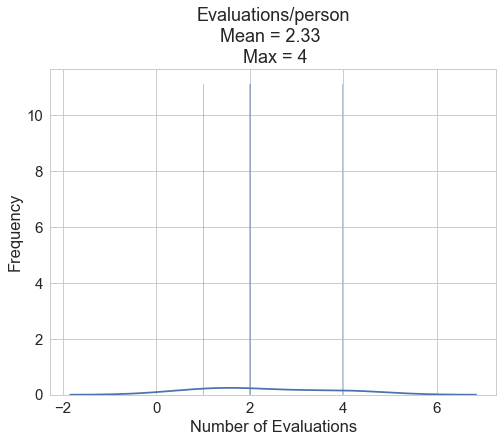

In [67]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

evalCounts = [len(x) for x in fair.groupby('user_id')['resource_name'].unique()]
avgCounts = sum(evalCounts)/len(evalCounts)


g = sn.distplot(evalCounts, bins=100)
g.set(xlabel='Number of Evaluations', ylabel='Frequency', 
       title="Evaluations/person\n Mean = "+str(round(avgCounts,2))+"  \n Max = "+str(max(evalCounts)))
plt.show()

## Are some raters harsher than others?

Evaluators gave a average FAIR score of 0.71 (on a 0-1 scale).


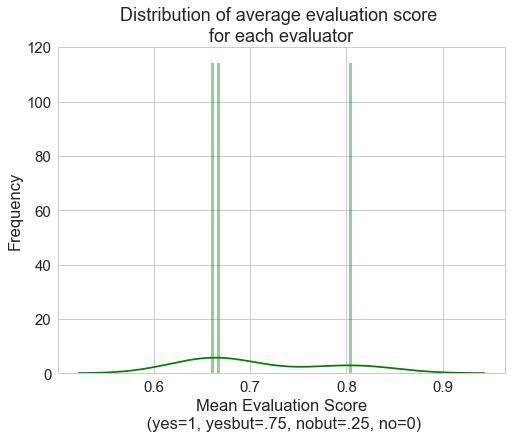

In [68]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

avgRating = fair.groupby('user_id')['user_id','answer01'].mean()
meanMean = avgRating['answer01'].mean()
g = sn.distplot(avgRating['answer01'], bins=50, color='green')
g.set(xlabel='Mean Evaluation Score\n (yes=1, yesbut=.75, nobut=.25, no=0)', ylabel='Frequency', 
       title="Distribution of average evaluation score \nfor each evaluator")

print("Evaluators gave a average FAIR score of "+str(round(meanMean,2)) + " (on a 0-1 scale).")
plt.show()

## Which answers tended to have the most comments

Questions 2. Metadata and 7. Contact most frequently had comments.


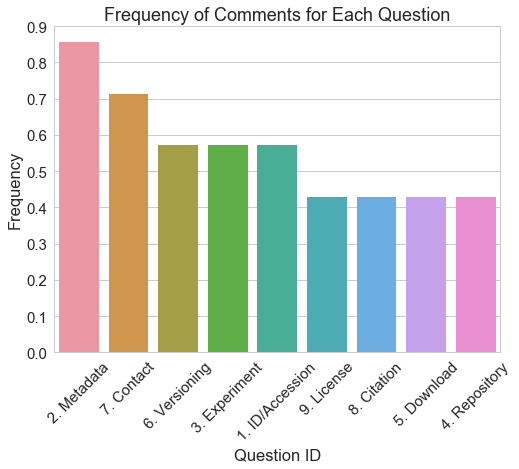

In [69]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

commentDict={}
for q in fair['q_name'].unique():
    sub = fair.loc[fair['q_name']==q]['comment']
    notEmpty = sum(~sub.isnull())/len(sub.isnull())
    commentDict[q] = notEmpty
commentDF = pd.Series(commentDict).sort_values(ascending=False)

g = sn.barplot(x=commentDF.index, y=commentDF )
g.set(xlabel='Question ID', ylabel='Frequency', 
       title="Frequency of Comments for Each Question")
plt.xticks(rotation=45, ha='center')
print("Questions "+commentDF.index[0]+" and "+commentDF.index[1]+ " most frequently had comments.")
plt.show()

## The FAIRest of the them all

In [70]:
resourceScores = fair.groupby('resource_name')['answer01'].mean().sort_values(ascending=False).reset_index()

FAIRest = resourceScores.loc[resourceScores['answer01']==max(resourceScores['answer01']),:]

print(FAIRest)

                      resource_name  answer01
0  The Rat Genome Database Datasets  0.888889


FAIRest resources (score = 0.888888888889)
                      resource_name  answer01
0  The Rat Genome Database Datasets  0.888889


Least FAIR resources ( score = 0.638888888889)
                                resource_name  answer01
1           Mouse Genome Informatics Datasets  0.722222
2                           WormBase Datasets  0.666667
3  The Zebrafish Information Network Datasets  0.666667
4           Gene Ontology Consortium Datasets  0.666667
5                            FlyBase Datasets  0.666667
6      Saccharomyces Genome Database Datasets  0.638889


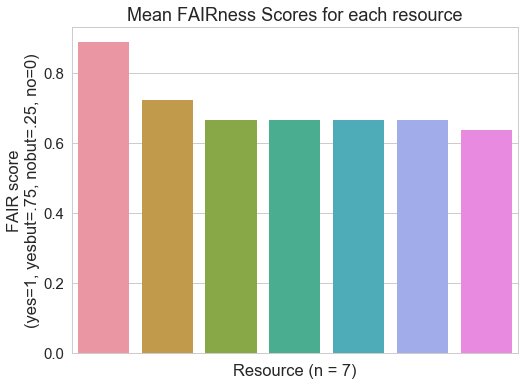

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

resourceScores = fair.groupby('resource_name')['answer01'].mean().sort_values(ascending=False).reset_index()
FAIRest = resourceScores.loc[resourceScores['answer01']==max(resourceScores['answer01']),:]
leastFAIR  = resourceScores.loc[resourceScores['answer01']< max(resourceScores['answer01']),:]

g = sn.barplot(data=resourceScores, x='resource_name', y='answer01')
g.set(xlabel='Resource (n = '+str(len(resourceScores))+')', ylabel='FAIR score\n(yes=1, yesbut=.75, nobut=.25, no=0)', 
       title="Mean FAIRness Scores for each resource")
g.set(xticklabels=[])

print("FAIRest resources (score = "+ str(max(resourceScores['answer01'])) +")")
print(FAIRest)
print("\n")
print("Least FAIR resources ( score = "+ str(min(resourceScores['answer01'])) +")")
print(leastFAIR)
plt.show()